# RNN Tutorial TensorFlow Example

#### Building RNN

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
n_inputs = 4
n_neurons = 6
n_timesteps = 2


In [3]:
## Data
X_batch = np.array([
    [[0,1,2,5],[9,8,7,4]], # Batch 1
    [[3,4,5,2],[0,0,0,0]], # Batch 2
    [[6,7,8,5],[6,5,4,2]],
])

In [4]:
# Define placeholder for the data
X = tf.placeholder(tf.float32, [None, n_timesteps, n_inputs])

#### Define the recurrent network

In [5]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [6]:
# compute the outputs and states
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [7]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    print(states.eval(feed_dict={X:X_batch}))
    print(outputs_val)
    print(outputs_val.shape)

[[-1.          0.94038534  0.20943306 -0.6943371   0.99907255  0.9733304 ]
 [-0.51283085  0.24804951 -0.50377005 -0.18931386  0.0266369  -0.8723675 ]
 [-0.99999607  0.8648998  -0.5652632  -0.63434374  0.97799957  0.33188003]]
[[[-0.9837008   0.3695819   0.9794493   0.94428724  0.9590109
    0.88615286]
  [-1.          0.94038534  0.20943306 -0.6943371   0.99907255
    0.9733304 ]]

 [[-0.9991032   0.9085767   0.7763827   0.29801202  0.6758122
    0.97306895]
  [-0.51283085  0.24804951 -0.50377005 -0.18931386  0.0266369
   -0.8723675 ]]

 [[-0.9999996   0.9765649   0.96189326  0.6676069   0.98852545
    0.9987626 ]
  [-0.99999607  0.8648998  -0.5652632  -0.63434374  0.97799957
    0.33188003]]]
(3, 2, 6)


## RNN in time series

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [9]:
def create_ts(start = '2001', n = 201, freq ='M'):
    rng = pd.date_range(start=start, periods=n, freq=freq)
    ts = pd.Series(np.random.uniform(-18, 18, size=len(rng)), rng).cumsum()
    return ts

In [10]:
ts = create_ts(start = '2001', n = 201, freq ='M')
ts.tail(5)

2017-05-31    110.698523
2017-06-30    111.483619
2017-07-31    113.047956
2017-08-31    117.378789
2017-09-30    109.199310
Freq: M, dtype: float64

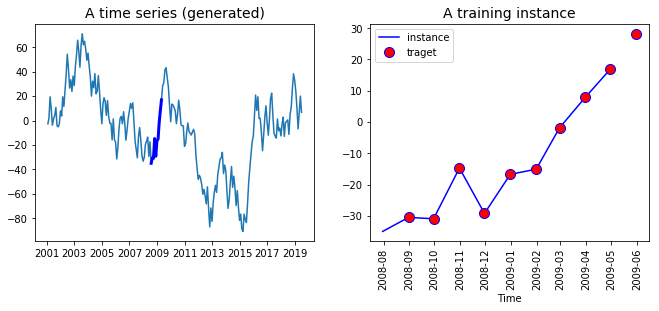

In [11]:
ts = create_ts(start='2001', n=222)

# Left
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(ts.index, ts)
plt.plot(ts.index[90:100], ts[90:100], 'b-', linewidth=3, label='A training instance')
plt.title('A time series (generated)', fontsize=14)

# Right
plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(ts.index[90:100], ts[90:100], "b-", markersize=8, label="instance")

# the y value is shifted my one period and represented my red dot
plt.plot(ts.index[91:101], ts[91:101], "bo", markersize=10, label="traget", markerfacecolor='red')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.xlabel("Time")

plt.show()

## Build an RNN to predict the Time Series in Tensorflow

##### Specifing some hyperparameters
* Number of input: 1
* Time step (windows in time series): 10
* Number of neurons: 120
* Number of output: 1

#### Create the train and test

In [12]:
# convert the series into a numpy array
series = np.array(ts)
n_windows = 20
n_input = 1
n_output = 1
size_train = 201

In [13]:
## Split data
train = series[:size_train]
test = series[size_train:]
print(train.shape, test.shape)

(201,) (21,)


#### Create the function to return X_batches and y_batches

In [14]:
# x_data = train[:size_train-1]: Select all the training instance minus one day
# X_batches = x_data.reshape(-1, windows, input): create the right shape for the batch e.g (10, 20, 1)
def create_batches(df, windows, input, output):
    ## Create X         
        x_data = train[:size_train-1] # Select the data
        X_batches = x_data.reshape(-1, windows, input)  # Reshape the data 
    ## Create y
        y_data = train[n_output:size_train]
        y_batches = y_data.reshape(-1, windows, output)
        return X_batches, y_batches

In [15]:
X_batches, y_batches = create_batches(df = train, 
                                    windows = n_windows,
                                    input = n_input,
                                    output = n_output)

In [16]:
print(X_batches.shape , y_batches.shape)

(10, 20, 1) (10, 20, 1)


In [17]:
X_test, y_test = create_batches(df = test, windows = 20, input = 1, output = 1)
print(X_test.shape, y_test.shape)

(10, 20, 1) (10, 20, 1)


#### Build the model

##### To create the model, we need to define three parts:
1. The variable with the tensors
2. The RNN
3. The loss and optimization

In [37]:
tf.reset_default_graph()
r_neuron = 120    

## 1. Construct the tensors
X = tf.placeholder(tf.float32, [None, n_windows, n_input])   
y = tf.placeholder(tf.float32, [None, n_windows, n_output])

## 2. create the model
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=r_neuron, activation=tf.nn.relu)   
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)              

"""
This is a bit tricker but allows faster computation. You need to transform the run output to a dense layer and then
convert it again to have the same dimension as the input.
"""
stacked_rnn_output = tf.reshape(rnn_output, [-1, r_neuron])          
stacked_outputs = tf.layers.dense(stacked_rnn_output, n_output)       
outputs = tf.reshape(stacked_outputs, [-1, n_windows, n_output])   

## 3. Loss + optimization
learning_rate = 0.001  
 
loss = tf.reduce_sum(tf.square(outputs - y))    
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)         
training_op = optimizer.minimize(loss)                                          

init = tf.global_variables_initializer()

In [38]:
iteration = 1500

with tf.Session() as sess:
    init.run()
    for iters in range(iteration):
        sess.run(training_op, feed_dict={X: X_batches, y: y_batches})
        if iters % 150 == 0:
            mse = loss.eval(feed_dict = {X: X_batches, y: y_batches})
            print(iters, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})

0 	MSE: 186186.75
150 	MSE: 10222.744
300 	MSE: 2765.4248
450 	MSE: 2147.8218
600 	MSE: 1820.3
750 	MSE: 1776.7307
900 	MSE: 1575.562
1050 	MSE: 1520.7144
1200 	MSE: 1415.7054
1350 	MSE: 1349.5448


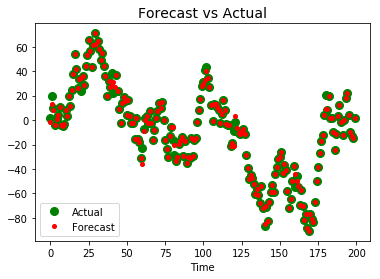

In [39]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')
plt.legend(loc="lower left")
plt.xlabel("Time")

plt.show()